### io_utils.py  (io(input output)와 관련된 함수를 짜놓은 코드) 
##### train.py의 train code가 import 하는 code들은 lib 폴더에 저장

<GCN, GIN 같은 Network를 만들기 전에 data를 전처리하는 과정>

3강. SMILES->Graph

파이토치 데이터셋과 데이터 로더 만들기

### 원본

In [2]:
import torch
import dgl
from rdkit import Chem

#therapeutics data commons라는 벤치마크 data set과 task를 제공하는 라이브러리
#tdc에서 벤치마트 data set 다운 (ADME - BBB_Martins)
from tdc.single_pred import ADME
from tdc.single_pred import HTS
from tdc.single_pred import Tox


ATOM_VOCAB = [
	'C', 'N', 'O', 'S', 'F', 
	'H', 'Si', 'P', 'Cl', 'Br',
	'Li', 'Na', 'K', 'Mg', 'Ca',
	'Fe', 'As', 'Al', 'I', 'B',
	'V', 'Tl', 'Sb', 'Sn', 'Ag', 
	'Pd', 'Co', 'Se', 'Ti', 'Zn',
	'Ge', 'Cu', 'Au', 'Ni', 'Cd',
	'Mn', 'Cr', 'Pt', 'Hg', 'Pb'
]


def one_of_k_encoding(x, vocab):
	if x not in vocab:
		x = vocab[-1]
	return list(map(lambda s: float(x==s), vocab))


def get_atom_feature(atom):
	atom_feature = one_of_k_encoding(atom.GetSymbol(), ATOM_VOCAB)
	atom_feature += one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5])
	atom_feature += one_of_k_encoding(atom.GetTotalNumHs(), [0, 1, 2, 3, 4])
	atom_feature += one_of_k_encoding(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5])
	atom_feature += [atom.GetIsAromatic()]
	return atom_feature
	

def get_bond_feature(bond):
	bt = bond.GetBondType()
	bond_feature = [
		bt == Chem.rdchem.BondType.SINGLE,
		bt == Chem.rdchem.BondType.DOUBLE,
		bt == Chem.rdchem.BondType.TRIPLE,
		bt == Chem.rdchem.BondType.AROMATIC,
		bond.GetIsConjugated(),
		bond.IsInRing()
	]
	return bond_feature


def get_molecular_graph(smi):
	mol = Chem.MolFromSmiles(smi)
	graph = dgl.DGLGraph()

	atom_list = mol.GetAtoms()
	num_atoms = len(atom_list)
	graph.add_nodes(num_atoms)

	atom_feature_list = [get_atom_feature(atom) for atom in atom_list]
	atom_feature_list = torch.tensor(atom_feature_list, dtype=torch.float64)
	graph.ndata['h'] = atom_feature_list

	bond_list = mol.GetBonds()
	bond_feature_list = []
	for bond in bond_list:
		bond_feature = get_bond_feature(bond)

		src = bond.GetBeginAtom().GetIdx()
		dst = bond.GetEndAtom().GetIdx()

		# DGL graph is undirectional
		# Thus, we have to add edge pair of both (i,j) and (j, i)
		# i --> j
		graph.add_edges(src, dst)
		bond_feature_list.append(bond_feature)

		# j --> i
		graph.add_edges(dst, src)
		bond_feature_list.append(bond_feature)
	
	bond_feature_list = torch.tensor(bond_feature_list, dtype=torch.float64)
	graph.edata['e_ij'] = bond_feature_list
	return graph


def get_smi_and_label(dataset):
	smi_list = list(dataset['Drug'])
	label_list = list(dataset['Y'])
	return smi_list, label_list


def my_collate_fn(batch):
	graph_list = []
	label_list = []
	for item in batch:
		smi = item[0]
		label = item[1]
		graph = get_molecular_graph(smi)
		graph_list.append(graph)
		label_list.append(label)
	graph_list = dgl.batch(graph_list)
	label_list = torch.tensor(label_list, dtype=torch.float64)
	return graph_list, label_list


def get_dataset(
		name,
		method='random',
		data_seed=999,
		frac=[0.7, 0.1, 0.2]
	):
	data = None
	if name == 'BBBP':
		data = ADME(
			name='BBB_Martins'
		)
	elif name == 'HIV':
		data = HTS(
			name='HIV'
		)
	elif name == 'hERG':
		data = Tox(
			name='hERG'
		)
	elif name == 'Solubility':
		data = ADME(
			name='Solubility_AqSolDB'
		)
	elif name == 'Lipophilicity':
		data = ADME(
			name='Lipophilicity_AstraZeneca'
		)

	split = data.get_split(
		method=method,
		seed=data_seed,
		frac=frac,
	)
	train_set = split['train']
	valid_set = split['valid']
	test_set = split['test']
	return train_set, valid_set, test_set


class MyDataset(torch.utils.data.Dataset):
	def __init__(
			self, 
			splitted_set
		):
		self.smi_list = list(splitted_set['Drug'])
		self.label_list = list(splitted_set['Y'])
	
	def __len__(self):
		return len(self.smi_list)
	
	def __getitem__(
			self, 
			idx
		):
		return self.smi_list[idx], self.label_list[idx]

def debugging():
	data = ADME(
		name='BBB_Martins'
	)
	split = data.get_split(
		method='random',
		seed=999,
		frac=[0.7, 0.1, 0.2],
	)
	train_set = split['train']
	valid_set = split['valid']
	test_set = split['test']
	
	smi_train, label_train = get_smi_and_label(train_set)
    #하나의 molecular graph (DGL graph)로 변환
    #이 graph를 NN에 넣으면 NN이 인식 하고 하나의 output 도출
	graph = get_molecular_graph(smi_train[0])


if __name__ == '__main__':
	debugging()

Downloading...
100%|██████████| 138k/138k [00:00<00:00, 337kiB/s] 
Loading...
Done!


### 주석

In [7]:
import torch
import dgl
from rdkit import Chem

from tdc.single_pred import ADME
from tdc.single_pred import HTS
from tdc.single_pred import Tox


ATOM_VOCAB = [
    'C', 'N', 'O', 'S', 'F', 
    'H', 'Si', 'P', 'Cl', 'Br',
    'Li', 'Na', 'K', 'Mg', 'Ca',
    'Fe', 'As', 'Al', 'I', 'B',
    'V', 'Tl', 'Sb', 'Sn', 'Ag', 
    'Pd', 'Co', 'Se', 'Ti', 'Zn',
    'Ge', 'Cu', 'Au', 'Ni', 'Cd',
    'Mn', 'Cr', 'Pt', 'Hg', 'Pb'
]

#<5th>
def one_of_k_encoding(x, vocab):
    if x not in vocab:
        x = vocab[-1]
    #x='C'/ s='C','N','O'...  x=3/ s=0,1,2,3,4,5
    #x==s → True/False
    #float(True/ False) → 1.0/ 0.0
    return list(map(lambda s: float(x==s), vocab))

#<4th>
def get_atom_feature(atom):
    #one-hot 인코딩한 atom feature들을 concatenation하여 return (40+6+5+6+1=58차원)
    atom_feature = one_of_k_encoding(atom.GetSymbol(), ATOM_VOCAB)  #↑
    atom_feature += one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5])
    atom_feature += one_of_k_encoding(atom.GetTotalNumHs(), [0, 1, 2, 3, 4])
    atom_feature += one_of_k_encoding(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5])
    atom_feature += [atom.GetIsAromatic()]
    return atom_feature

#<7th> (화학) AROMATIC결합은 1.5중 결하이라고도 한다.
def get_bond_feature(bond):
    bt = bond.GetBondType()
    bond_feature = [
        bt == Chem.rdchem.BondType.SINGLE,
        bt == Chem.rdchem.BondType.DOUBLE,
        bt == Chem.rdchem.BondType.TRIPLE,
        bt == Chem.rdchem.BondType.AROMATIC,
        bond.GetIsConjugated(),
        bond.IsInRing()
    ]
    return bond_feature

#<3rd> SMILES -> DGLGraph
def get_molecular_graph(smi):
    mol = Chem.MolFromSmiles(smi)
    #임의의 dgl graph 선언
    graph = dgl.DGLGraph()

    atom_list = mol.GetAtoms()
    num_atoms = len(atom_list)
    #atom의 개수가 node의 개수니까, 선언한 graph에 atom 개수만큼 node를 추가
    graph.add_nodes(num_atoms)

    #atom하나당 각각 58차원으로 된 atom feature으로 전체 atom의 이차원 리스트
    atom_feature_list = [get_atom_feature(atom) for atom in atom_list] #↑
    #<6th> 리스트 형태의 type을 torch tensor로 변환해 줌
    atom_feature_list = torch.tensor(atom_feature_list, dtype=torch.float64)
    #선언한 graph의 node data로 전체 node의 atom feature list를 추가해 줌
    graph.ndata['h'] = atom_feature_list
    

    bond_list = mol.GetBonds()
    #bond_feature_list = [get_bond_feature(bond) for bond in bond_list] 를 안하는 이유: for문 돌리면서 bond에서 더 얻을게 있음. 그리고 같은 bond_feature가 두번 들어감.
    bond_feature_list = []
    for bond in bond_list:
        bond_feature = get_bond_feature(bond) #↑
    
        #<8th> bond의 source node index, destination node index
        src = bond.GetBeginAtom().GetIdx()
        dst = bond.GetEndAtom().GetIdx()

        # DGL graph is undirectional
        # Thus, we have to add edge pair of both (i,j) and (j, i)
        # i --> j (node i에서 node j로 가는 message)
        # 그래프에 edge(i,j) 하나 추가
        graph.add_edges(src, dst)
        # bond feature 리스트에 edge(i,j) feature 하나 추가
        bond_feature_list.append(bond_feature)

        # j --> i (node j에서 node i로 가는 message. 이때, 같은 bond이므로 bond feature는 i->j , j->i가 똑같음, 따라서 똑같은 bond feature가 두번 들어가게 됨)
        # 그래프에 edge 하나 추가
        graph.add_edges(dst, src)
        # bond feature 리스트에 edge(j,i) feature = edge(i,j) feature하나 추가
        bond_feature_list.append(bond_feature)

    # list -> tensor / data type 변환: int나 boolean type -> float으로 바꿔줌
    bond_feature_list = torch.tensor(bond_feature_list, dtype=torch.float64)
    #선언한 graph의 edge data로 전체 bond의 edge feature list를 추가해 줌
    graph.edata['e_ij'] = bond_feature_list
    # graph에 add_nodes(노드추가) -> ndata(노드피처추가) -> add_edges(엣지추가) -> edata(엣지피처추가) 전부 선언
    return graph

#<2nd>
def get_smi_and_label(dataset):
    smi_list = list(dataset['Drug'])
    label_list = list(dataset['Y'])
    return smi_list, label_list

# batch_size가 32라면 한 batch에 SMILES 32개 , Label 32개
def my_collate_fn(batch):
    graph_list = []
    label_list = []
    # batch에서 item하나 씩
    for item in batch:
        # SMILES는 item의 0번째
        smi = item[0]
        # Label은 item의 첫번째
        label = item[1]
        # SMILES에 대해서 graph로 변환
        graph = get_molecular_graph(smi)
        # graph 32개
        graph_list.append(graph)
        # label 32개
        label_list.append(label)
    # dgl.batch: 하나의 batch로 만듦. (node/edge feature flattening)
    # 각 molecule 마다 node 개수가 다를것. (첫번째 SMILES의 노드:3개)(두번쨰..:5개)(세번쨰..:2개) 일 떄 -> 0,1,2/0,1,2,3,4/0,1/..../32번째 SMILES의 노드개수
    # 이것들을  0,1,2/3,4,5,6,7/8,9/..../32번째 SMILES의 노드개수 (일종의 flattening)
    # 이렇게 하는 이유는 sparce graph로 만들기 위해서 즉, node/edge feature들이 0으로 채워지는 것을 최소화하기 위하여
    graph_list = dgl.batch(graph_list)
    label_list = torch.tensor(label_list, dtype=torch.float64)
    return graph_list, label_list


def get_dataset(
        #training하고자 하는 property
        name,
        method='random',
        data_seed=999,
        frac=[0.7, 0.1, 0.2]
    ):
    data = None
    if name == 'BBBP':
        # ADME 클래스 에서 BBB_Martins 데이터를 다운받아라
        data = ADME(
            name='BBB_Martins'
        )
    elif name == 'HIV':
        data = HTS(
            name='HIV'
        )
    elif name == 'hERG':
        data = Tox(
            name='hERG'
        )
    elif name == 'Solubility':
        data = ADME(
            name='Solubility_AqSolDB'
        )
    elif name == 'Lipophilicity':
        data = ADME(
            name='Lipophilicity_AstraZeneca'
        )

    # 다운받은 데이터를 splitting
    split = data.get_split(
        # random splitting할거냐, scafold splitting할거냐 
        method=method,
        # data seed는 111, 222, 333, 999 이 data seed를 바꿔가면서 k-fold cross validation 하는게 실제로는 필요함
        seed=data_seed,
        # train / validation / test set 비율 
        frac=frac,
        )
    train_set = split['train']
    valid_set = split['valid']
    test_set = split['test']
    return train_set, valid_set, test_set

            
class MyDataset(torch.utils.data.Dataset):
    def __init__(
            self, 
            splitted_set
        ):
        self.smi_list = list(splitted_set['Drug'])
        self.label_list = list(splitted_set['Y'])
    
    def __len__(self):
        return len(self.smi_list)
    
    # a=MyDataset() , a.smi_list[idx] ---> a[idx]
    def __getitem__(
            self, 
            idx
        ):
        return self.smi_list[idx], self.label_list[idx]

#<1st>
def debugging():
    #데이터셋 다운
    data = ADME(
        name='BBB_Martins'
    )
    #random한 방법으로, random seed는 999번쨰로, train/vailation/test set으로 split
    split = data.get_split(
        method='random',
        seed=999,
        frac=[0.7, 0.1, 0.2],
    )
    # type(train_set) --- <class 'pandas.core.frame.DataFrame'>
    train_set = split['train']
    valid_set = split['valid']
    test_set = split['test']
    
    smi_train, label_train = get_smi_and_label(train_set)  #↑
    graph = get_molecular_graph(smi_train[0])  #↑

# 다른 스크립트에서 이 io_utils.py 모듀을 import하면 실행되지 않는 부분
if __name__ == '__main__':
	debugging()

Found local copy...
Loading...
Done!


### 연습

In [13]:
ATOM_VOCAB = [
	'C', 'N', 'O', 'S', 'F', 
	'H', 'Si', 'P', 'Cl', 'Br',
	'Li', 'Na', 'K', 'Mg', 'Ca',
	'Fe', 'As', 'Al', 'I', 'B',
	'V', 'Tl', 'Sb', 'Sn', 'Ag', 
	'Pd', 'Co', 'Se', 'Ti', 'Zn',
	'Ge', 'Cu', 'Au', 'Ni', 'Cd',
	'Mn', 'Cr', 'Pt', 'Hg', 'Pb'
]


def one_of_k_encoding(x, vocab):
	if x not in vocab:
		x = vocab[-1]
	return list(map(lambda s: float(x==s), vocab))
                   #lamda func(x):
                   #     return float()


def get_atom_feature(atom):
    atom_feature = one_of_k_encoding(atom.GetSymbol(), ATOM_VOCAB)
    return atom_feature

In [22]:
data = ADME(name='BBB_martins')
split = data.get_split(method='random', frac=[0.7, 0.1, 0.2], seed=999)
train_set = split['train']
valid_set = split['valid']
test_set = split['test']
smi_list = list(train_set['Drug'])
smi = smi_list[0]
mol = Chem.MolFromSmiles(smi)
mol
atom_list = mol.GetAtoms()
atom = atom_list[0]

print(get_atom_feature(atom))

Found local copy...
Loading...
Done!


[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [20]:
len(get_atom_feature(atom))

40

In [15]:
1 == 1

True

In [16]:
1 == 0

False

In [17]:
float(1 == 1)

1.0

In [18]:
float(1 == 0)

0.0

In [19]:
a=[1]
b=[2]
c=[3]

alll=[a,b,c]

re = [ d for d in alll ]
re

[[1], [2], [3]]

In [21]:
torch.tensor(re, dtype=torch.float64)

tensor([[1.],
        [2.],
        [3.]], dtype=torch.float64)

In [23]:
atom_feature = []
atom_feature += [atom.GetIsAromatic()]
atom_feature

[False]

### 데이터셋 다운 받고 train/vailation/test set으로 쪼개기

In [11]:
from tdc.single_pred import ADME

data = ADME(name='BBB_martins')
split = data.get_split(method='random', frac=[0.7, 0.1, 0.2], seed=999) #frac=train,validation,test set
print(type(split))
print(type(split['train']))
print(split)

Found local copy...
Loading...
Done!


<class 'dict'>
<class 'pandas.core.frame.DataFrame'>
{'train':                                 Drug_ID  \
0                  Terbutylchlorambucil   
1                                 40730   
2                           cloxacillin   
3                          cefoperazone   
4                      rolitetracycline   
...                                 ...   
1416                         zometapine   
1417                         licostinel   
1418  ademetionine(adenosyl-methionine)   
1419                           mesocarb   
1420                         tofisoline   

                                                   Drug  Y  
0                CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1  1  
1      CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23  1  
2     Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...  1  
3     CCN1CCN(C(=O)N[C@@H](C(=O)N[C@@H]2C(=O)N3C(C(=...  1  
4     CN(C)[C@@H]1C(=O)/C(=C(/O)NCN2CCCC2)C(=O)[C@@]...  1  
...                                                 ..

In [6]:
train_set = split['train']
valid_set = split['valid']
test_set = split['test']

In [12]:
print(type(train_set))
train_set

<class 'pandas.core.frame.DataFrame'>


,Drug_ID,Drug,Y
0,Terbutylchlorambucil,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1
1,40730,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1
2,cloxacillin,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1
3,cefoperazone,CCN1CCN(C(=O)N[C@@H](C(=O)N[C@@H]2C(=O)N3C(C(=...,1
4,rolitetracycline,CN(C)[C@@H]1C(=O)/C(=C(/O)NCN2CCCC2)C(=O)[C@@]...,1
...,...,...,...
1416,zometapine,CC1=C2C(c3cccc(Cl)c3)=NCCN=C2N(C)N1,1
1417,licostinel,O=c1[nH]c2cc(Cl)c(Cl)c([N+](=O)[O-])c2[nH]c1=O,1
1418,ademetionine(adenosyl-methionine),C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc...,1
1419,mesocarb,CC(Cc1ccccc1)n1cc([N-]C(=O)Nc2ccccc2)[o+]n1,1


In [13]:
smi_list = list(train_set['Drug'])
len(smi_list)

1421

In [19]:
label_list = list(train_set['Y'])
type(label_list[0])  #int type 이므로 나중에 dataset에 넣을 떄 float 형태로 변환

int

### GNN: 분자의 구조를 SMILES로부터 graph로 바꾸기

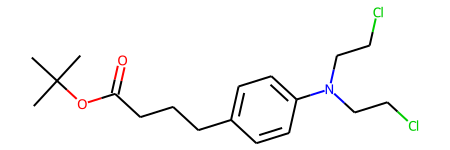

In [20]:
from rdkit import Chem

smi = smi_list[0]
mol = Chem.MolFromSmiles(smi)
mol

In [22]:
# graph 중에서 node에 해당이 되는 원자 feature 얻기
atom_list = mol.GetAtoms()
atom = atom_list[0]
atom.GetSymbol()

'C'

In [23]:
atom.GetDegree()    #이 원자에 팔이 몇개 달려있느냐 (directly-bonded neighbors)

1

In [24]:
atom.GetTotalNumHs()  #보통 분자그래프에서 수소는 생략 하는데, 수소가 아닌 원자(node)에 수소가 몇개 붙어있는지 feature로 같이 넣어줌

3

In [25]:
atom.GetImplicitValence()

3

In [36]:
atom.GetIsAromatic()

False

In [29]:
# graph 중에서 edge에 해당이 되는 결합 feature 얻기
bond_list = mol.GetBonds()
bond = bond_list[0]
bond.GetBeginAtom().GetIdx()

0

In [30]:
bond.GetEndAtom().GetIdx()

1

In [31]:
bond.GetBondType()

rdkit.Chem.rdchem.BondType.SINGLE

In [32]:
bond.IsInRing()

False

In [33]:
bond.GetIsConjugated()

False

In [ ]:
def one_of_k_encoding(x, vocab):
	if x not in vocab:
		x = vocab[-1]
	return list(map(lambda s: float(x==s), vocab))
                   #lamda func(x):
                   #     return float()

In [2]:
ATOM_VOCAB = [
	'C', 'N', 'O', 'S', 'F', 
	'H', 'Si', 'P', 'Cl', 'Br',
	'Li', 'Na', 'K', 'Mg', 'Ca',
	'Fe', 'As', 'Al', 'I', 'B',
	'V', 'Tl', 'Sb', 'Sn', 'Ag', 
	'Pd', 'Co', 'Se', 'Ti', 'Zn',
	'Ge', 'Cu', 'Au', 'Ni', 'Cd',
	'Mn', 'Cr', 'Pt', 'Hg', 'Pb'
]

def func(x):
    return float(x==s)

atom_feature = one_of_k_encoding(atom.GetSymbol(), ATOM_VOCAB)

NameError: name 'atom' is not defined

In [9]:
#[in, out1, out2]
layer_size = [1, 10, 100]

for in_channels, out_channels in zip(layer_size, layer_size[1:]):
    print( in_channels , out_channels )
            #  in   out1
            # out1  out2

1 10
10 100


In [12]:
print( zip(layer_size, layer_size[1:]) )

In [13]:
layer_size[1:]

[10, 100]

In [14]:
layer_size

[1, 10, 100]